In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
import wfdb.processing as wp
import matplotlib.pyplot as plt
from scipy import signal
from utils import find_noise_features, extract_basic_features
import warnings
import shutil

import time
from lightgbm import LGBMClassifier
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
path = "F:\\ECG数据集\\www.physionet.org\\physiobank\\database\\afdb\\"
record_name = "04048"

In [2]:
def cinc_f1_score(ref, ans, verbose=True, details=False):
    assert (ref.shape[0] == ans.shape[0])

    AA = np.zeros((4, 4))

    for n in range(ref.shape[0]):
        rec = ref[n]

        this_answer = ans[n]

        if rec == 0:
            if this_answer == 0:
                AA[0, 0] += 1
            elif this_answer == 1:
                AA[0, 1] += 1
            elif this_answer == 2:
                AA[0, 2] += 1
            elif this_answer == 3:
                AA[0, 3] += 1

        elif rec == 1:
            if this_answer == 0:
                AA[1, 0] += 1
            elif this_answer == 1:
                AA[1, 1] += 1
            elif this_answer == 2:
                AA[1, 2] += 1
            elif this_answer == 3:
                AA[1, 3] += 1

        elif rec == 2:
            if this_answer == 0:
                AA[2, 0] += 1
            elif this_answer == 1:
                AA[2, 1] += 1
            elif this_answer == 2:
                AA[2, 2] += 1
            elif this_answer == 3:
                AA[2, 3] += 1

        elif rec == 3:
            if this_answer == 0:
                AA[3, 0] += 1
            elif this_answer == 1:
                AA[3, 1] += 1
            elif this_answer == 2:
                AA[3, 2] += 1
            elif this_answer == 3:
                AA[3, 3] += 1

    F1n = 2 * AA[0, 0] / (sum(AA[0, :]) + sum(AA[:, 0]))
    F1a = 2 * AA[1, 1] / (sum(AA[1, :]) + sum(AA[:, 1]))
    F1o = 2 * AA[2, 2] / (sum(AA[2, :]) + sum(AA[:, 2]))
    F1p = 2 * AA[3, 3] / (sum(AA[3, :]) + sum(AA[:, 3]))
    F1 = (F1n + F1a + F1o) / 3
    if details:
        print(AA)
    if verbose:
        print('F1 measure for Normal rhythm: ' '%1.4f' % F1n)
        print('F1 measure for AF rhythm: ' '%1.4f' % F1a)
        print('F1 measure for Other rhythm: ' '%1.4f' % F1o)
        print('F1 measure for Noisy recordings: ' '%1.4f' % F1p)
        print('Final F1 measure: ' '%1.4f' % F1)

    return F1n,F1a,F1o,F1p,F1

In [3]:
feature38_name = ['CV','rmssd','QRS_Width_std','MAD','AFEv','IrrEv','OriginCount','PACEv','R_amp_std','RR_mean',
           'RR_min','HR_median','RR_max','CV_deltaRR','Pf_1','Pf_2','pf_RR_1','pf_RR_2','pf_RR_3','se', 
           'nn50', 'percentage_nn50', 'arrhyth_ind', 'res_kstest','COSEn', 'Radius','similar_ind_QRS','similar_ind_Ramp',
           'r_high_similarbeats','stepping', 'E','MOBILITY','COMPLEXITY','R_amp_CV', 'QRS_width_mean','sk_RR','kurt_RR','RR_range']
feature16_name=[]
for i in [6,5,26,25,22,30,24,36,20,7,32,1,33,12,21,29]:
    feature16_name.append(feature38_name[i-1])
feature39_name = [
    "var", "skew", "kurtosis", "perdiogram_1", "perdiogram_2", "perdiogram_3",
    "perdiogram_4", "qrs_areas_mean", "qrs_areas_max", "qrs_areas2_mean",
    "qrs_areas2_max", "qrs_malin_mean", "qrs_malin_max", "qrs_malin2_mean",
    "qrs_malin2_max", "n_plus_mean", "n_plus_max", "n_plus2_mean",
    "n_plus2_max", "v40_mean", "v40_max", "v40_2_mean", "v40_2_max",
    "freq_ratio_1", "freq_ratio_2", "freq_ratio_3", "freq_ratio_4",
    "freq_ratio_5", "lorenz_plot", "rr_var", "rr_var_1", "rr_var_2", "log_rr",
    "log_rr_1_abs", "sample_entropy_1", "sample_entropy_2",
    "shannon_entropy_1", "shannon_entropy_2", "correlation"
]
def generate_feature188():
    a="Features_SD_1"
    feature_name = []
    for i in range(1,69,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a="Features_RB_1"
    for i in range(1,16,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a="Features_ADC_1"
    for i in range(1,22,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a='Features_embcsoa_1'
    for i in range(1,9,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a="Features_CP_1"
    for i in range(1,28,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a='features_temp_1'
    for i in range(1,20,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a='features_temp_rs_1'
    for i in range(1,31,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b
    return feature_name
feature188_name = generate_feature188()

In [4]:
path = "F:\\ECG\\ecg\\training2017\\"
f_list = os.listdir(path)
file_list = []
for i in f_list:
    # os.path.splitext():分离文件名与扩展名
    if os.path.splitext(i)[1] == '.mat':
        file_list.append(i.split(".")[0])

In [5]:
#读取39个特征数据
if os.path.isfile("cinc_feat.csv"):
    features39_pd = pd.read_csv("cinc_feat.csv")
features39_pd.head()

,id,var,skew,kurtosis,perdiogram_1,perdiogram_2,perdiogram_3,perdiogram_4,qrs_areas_mean,qrs_areas_max,...,rr_var,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation
0,A00001,0.000111,2.909595,11.207767,-5022.949108,-4897.418491,-6417.626901,-8600.342510,0.348011,0.602488,...,0.000049,0.000022,0.000044,11.201408,0.781425,3.782768,2.772589,4.504121,4.499598,0.006479
1,A00002,0.000111,2.935605,15.180122,-4976.180846,-4776.655937,-6577.618563,-8395.064863,0.295944,0.919263,...,0.001101,0.002392,0.008281,9.144809,2.459695,1.916463,1.592631,4.640224,4.694019,0.117561
2,A00003,0.000056,-1.580090,4.994374,-10358.327470,-10455.589720,-14087.272830,-18263.731720,-0.091824,0.200487,...,0.000146,0.000197,0.000517,19.644293,2.044110,2.211211,1.800493,5.167088,5.119668,0.025986
3,A00004,0.000111,3.551206,14.768413,-4898.854941,-4707.588663,-6478.057380,-8517.461309,0.415471,0.506781,...,0.001151,0.001939,0.005273,9.152490,3.104567,2.984304,2.890372,4.640224,4.789015,0.038117
4,A00005,0.000056,2.303823,8.327276,-10835.293760,-10181.270340,-13613.273700,-17518.596880,0.119709,0.540239,...,0.001371,0.001967,0.004816,22.598280,10.004504,2.332943,1.735189,6.079932,6.396046,0.026922


In [6]:
#读取188个特征数据
path = "F:\\ECG\\ecg\\training2017\\"
if os.path.isfile("cinc_feat188.csv"):
    features188_pd = pd.read_csv("cinc_feat188.csv")
else:
    data = np.loadtxt(path+"TH902_features_188.txt")
    features188_pd = pd.DataFrame(data,columns=feature188_name,index=file_list)
     
    features188_pd['id']=file_list
    col = feature188_name.copy()
    col.insert(0,'id')
    #features15_pd = features15_pd.reindex(columns=col)
    features188_pd.to_csv("cinc_feat188.csv",index=False)
features188_pd.head()

,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,Features_SD_10,...,features_temp_rs_22,features_temp_rs_23,features_temp_rs_24,features_temp_rs_25,features_temp_rs_26,features_temp_rs_27,features_temp_rs_28,features_temp_rs_29,features_temp_rs_30,id
0,-11.0,11.0,0.0,0.0,0.0,0.0,0.044264,0.031529,0.039185,0.013482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00001
1,9.0,7.0,16.0,0.0,0.0,4.0,0.325171,0.296396,0.298329,0.171309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00002
2,-26.0,31.0,5.0,0.0,0.0,3.0,0.093895,0.088135,0.064279,0.056015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00003
3,26.0,0.0,26.0,0.0,1.0,5.0,0.195561,0.251051,0.318723,0.107943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00004
4,57.0,10.0,75.0,4.0,9.0,15.0,0.412665,0.503457,0.537868,0.263645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00005


In [7]:
path = "./wclfeature/"
features38_pd = pd.read_csv(path+"cinc_feat.csv",header=None)
features38_pd.drop([0,39],axis=1,inplace=True)
features38_pd.columns = feature38_name
features38_pd['id']=file_list
features38_pd.head()

,CV,rmssd,QRS_Width_std,MAD,AFEv,IrrEv,OriginCount,PACEv,R_amp_std,RR_mean,...,stepping,E,MOBILITY,COMPLEXITY,R_amp_CV,QRS_width_mean,sk_RR,kurt_RR,RR_range,id
0,0.04,0.00,0.00,0.03,-6.0,0.0,6.0,0.0,0.09,0.76,...,0.04,11.90,0.16,9.03,0.11,0.07,0.12,1.80,0.11,A00001
1,0.04,0.00,0.00,0.03,-6.0,0.0,6.0,0.0,0.07,1.03,...,0.04,-0.95,0.24,5.89,0.10,0.07,-0.41,2.62,0.13,A00002
2,0.10,0.01,0.01,0.04,-14.0,8.0,22.0,0.0,0.12,0.74,...,0.11,21.17,0.20,8.28,-0.26,0.07,0.18,11.10,0.61,A00003
3,0.19,0.06,0.00,0.15,26.0,26.0,0.0,0.0,0.11,0.95,...,0.32,0.12,0.30,5.23,0.09,0.07,0.48,2.05,0.62,A00004
4,0.41,0.07,0.01,0.18,58.0,76.0,8.0,5.0,0.16,0.54,...,0.53,28.54,0.48,3.29,0.17,0.06,1.18,3.02,0.78,A00005


In [8]:
#组合全部特征
train_data = pd.merge(features188_pd,features38_pd,on='id')
train_data = pd.merge(train_data,features39_pd,on='id')
train_data.head()

,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,Features_SD_10,...,rr_var,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation
0,-11.0,11.0,0.0,0.0,0.0,0.0,0.044264,0.031529,0.039185,0.013482,...,0.000049,0.000022,0.000044,11.201408,0.781425,3.782768,2.772589,4.504121,4.499598,0.006479
1,9.0,7.0,16.0,0.0,0.0,4.0,0.325171,0.296396,0.298329,0.171309,...,0.001101,0.002392,0.008281,9.144809,2.459695,1.916463,1.592631,4.640224,4.694019,0.117561
2,-26.0,31.0,5.0,0.0,0.0,3.0,0.093895,0.088135,0.064279,0.056015,...,0.000146,0.000197,0.000517,19.644293,2.044110,2.211211,1.800493,5.167088,5.119668,0.025986
3,26.0,0.0,26.0,0.0,1.0,5.0,0.195561,0.251051,0.318723,0.107943,...,0.001151,0.001939,0.005273,9.152490,3.104567,2.984304,2.890372,4.640224,4.789015,0.038117
4,57.0,10.0,75.0,4.0,9.0,15.0,0.412665,0.503457,0.537868,0.263645,...,0.001371,0.001967,0.004816,22.598280,10.004504,2.332943,1.735189,6.079932,6.396046,0.026922


In [9]:
#读取标签
path = "F:\\ECG\\ecg\\training2017\\"
target = pd.read_csv(os.path.join(path,"REFERENCE-v3.csv"),header=None,index_col=False)
target.columns=["ID","label"]
target.head()

,ID,label
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A


In [10]:
train_data["label"] = np.array(target["label"])#target["label"]
train_data.head()

,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,Features_SD_10,...,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation,label
0,-11.0,11.0,0.0,0.0,0.0,0.0,0.044264,0.031529,0.039185,0.013482,...,0.000022,0.000044,11.201408,0.781425,3.782768,2.772589,4.504121,4.499598,0.006479,N
1,9.0,7.0,16.0,0.0,0.0,4.0,0.325171,0.296396,0.298329,0.171309,...,0.002392,0.008281,9.144809,2.459695,1.916463,1.592631,4.640224,4.694019,0.117561,N
2,-26.0,31.0,5.0,0.0,0.0,3.0,0.093895,0.088135,0.064279,0.056015,...,0.000197,0.000517,19.644293,2.044110,2.211211,1.800493,5.167088,5.119668,0.025986,N
3,26.0,0.0,26.0,0.0,1.0,5.0,0.195561,0.251051,0.318723,0.107943,...,0.001939,0.005273,9.152490,3.104567,2.984304,2.890372,4.640224,4.789015,0.038117,A
4,57.0,10.0,75.0,4.0,9.0,15.0,0.412665,0.503457,0.537868,0.263645,...,0.001967,0.004816,22.598280,10.004504,2.332943,1.735189,6.079932,6.396046,0.026922,A


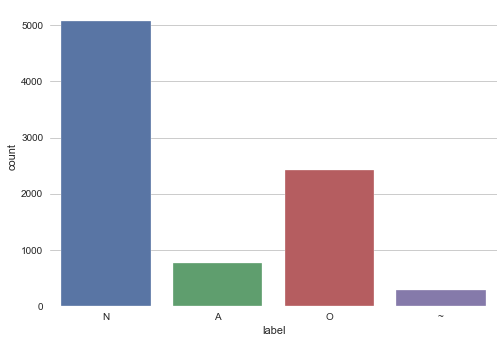

In [11]:
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.float_format', lambda x: '%.8f' % x)

sns.set_style('whitegrid')
sns.countplot(train_data[train_data['E'].notnull()].reset_index()["label"])

In [12]:
train_df = train_data[train_data['E'].notnull()].reset_index()

train_labels = train_df['label']
map_dict = {"N":0,"A":1,"O":0,"~":0}
train_labels = train_labels.map(map_dict)
train_df["label"] = train_labels.values#target["label"]
train_df.head()

,index,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,...,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation,label
0,0,-11.00000000,11.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04426400,0.03152900,0.03918500,...,0.00002230,0.00004430,11.20140801,0.78142460,3.78276817,2.77258872,4.50412060,4.49959762,0.00647882,0
1,1,9.00000000,7.00000000,16.00000000,0.00000000,0.00000000,4.00000000,0.32517100,0.29639600,0.29832900,...,0.00239223,0.00828122,9.14480873,2.45969485,1.91646295,1.59263079,4.64022393,4.69401936,0.11756109,0
2,2,-26.00000000,31.00000000,5.00000000,0.00000000,0.00000000,3.00000000,0.09389500,0.08813500,0.06427900,...,0.00019736,0.00051699,19.64429350,2.04411026,2.21121082,1.80049315,5.16708805,5.11966798,0.02598626,0
3,3,26.00000000,0.00000000,26.00000000,0.00000000,1.00000000,5.00000000,0.19556100,0.25105100,0.31872300,...,0.00193868,0.00527312,9.15248984,3.10456705,2.98430358,2.89037176,4.64022393,4.78901548,0.03811713,1
4,4,57.00000000,10.00000000,75.00000000,4.00000000,9.00000000,15.00000000,0.41266500,0.50345700,0.53786800,...,0.00196747,0.00481638,22.59828023,10.00450437,2.33294272,1.73518912,6.07993157,6.39604595,0.02692229,1


In [13]:
train_df["label"].value_counts()

0    7770
1     758
Name: label, dtype: int64

In [14]:
feature_name = ['sk_RR',
 'Features_SD_55',
 'features_temp_11',
 'pf_RR_1',
 'Features_SD_22',
 'Features_SD_48',
 'Features_embcsoa_8',
 'qrs_malin2_max',
 'Features_ADC_9',
 'Features_SD_16',
 'sample_entropy_2',
 'n_plus_mean',
 'RR_min',
 'Features_SD_47',
 'Features_SD_13',
 'CV_deltaRR',
 'Features_CP_15',
 'sample_entropy_1',
 'features_temp_2',
 'AFEv',
 'se',
 'r_high_similarbeats',
 'qrs_malin_max',
 'v40_mean',
 'Features_SD_64',
 'Features_CP_18',
 'rr_var_2',
 'Features_ADC_6',
 'features_temp_rs_13',
 'qrs_malin_mean',
 'features_temp_rs_15',
 'Features_RB_6',
 'lorenz_plot',
 'qrs_malin2_mean',
 'Features_SD_57',
 'Features_SD_14',
 'Features_CP_17',
 'Features_RB_4',
 'features_temp_rs_7',
 'Features_SD_52',
 'Features_CP_12',
 'Features_SD_33',
 'Features_ADC_2',
 'Features_SD_44',
 'features_temp_rs_2',
 'Features_SD_1',
 'Features_SD_58',
 'features_temp_rs_8',
 'features_temp_rs_17',
 'Features_SD_41',
 'Features_CP_4',
 'R_amp_CV',
 'Features_RB_11',
 'Features_SD_37',
 'Radius',
 'Features_SD_46',
 'Features_ADC_13',
 'Features_CP_8',
 'Features_CP_22',
 'Features_SD_60',
 'IrrEv',
 'features_temp_12',
 'Features_RB_10',
 'kurt_RR',
 'Features_SD_28',
 'Features_SD_59',
 'Features_CP_7',
 'perdiogram_1',
 'features_temp_rs_16',
 'Features_SD_35',
 'Features_SD_51',
 'v40_2_mean',
 'Features_CP_26',
 'Features_ADC_10',
 'Features_RB_13',
 'Features_SD_45',
 'Features_CP_25',
 'COSEn',
 'Features_SD_43',
 'Features_RB_9',
 'Features_SD_42',
 'Features_SD_38',
 'Features_RB_8',
 'Features_ADC_3',
 'n_plus2_mean',
 'features_temp_rs_1',
 'Features_SD_39',
 'Features_RB_14',
 'Features_CP_14',
 'Features_CP_19',
 'Features_CP_16',
 'Features_SD_36',
 'Features_RB_12',
 'RR_max',
 'Features_SD_56',
 'Features_CP_20',
 'Features_SD_62',
 'features_temp_3',
 'features_temp_rs_10',
 'HR_median'][:20]

len(feature_name)#43：0.8132 0.8232    48：0.8143 -0.8260  51 0.8088-0.8233
#feature_name = feature39_name+feature38_name+feature188_name[:175]
#feature_name = feature16_name
len(feature_name)

20

In [15]:
#二分类前100特征排名
feature_name =['AFEv',
 'sk_RR',
 'Features_SD_16',
 'Features_ADC_9',
 'features_temp_2',
 'IrrEv',
 'Radius',
 'Features_SD_44',
 'Features_ADC_3',
 'Features_ADC_6',
 'Features_ADC_2',
 'Features_SD_48',
 'Features_ADC_11',
 'Features_SD_1',
 'sample_entropy_1',
 'Features_CP_8',
 'n_plus_mean',
 'CV_deltaRR',
 'Features_ADC_7',
 'qrs_malin2_mean',
 'Features_CP_18',
 'Features_CP_20',
 'v40_2_mean',
 'Features_CP_19',
 'Features_SD_46',
 'Features_ADC_13',
 'Features_SD_60',
 'Features_RB_13',
 'R_amp_std',
 'features_temp_11',
 'Features_SD_43',
 'sample_entropy_2',
 'RR_min',
 'COSEn',
 'features_temp_3',
 'Features_CP_22',
 'se',
 'Features_SD_51',
 'Features_SD_55',
 'Features_CP_16',
 'Features_SD_56',
 'Features_SD_52',
 'Features_SD_45',
 'features_temp_rs_1',
 'percentage_nn50',
 'HR_median',
 'shannon_entropy_1',
 'qrs_areas_mean',
 'pf_RR_1',
 'Features_RB_14',
 'Features_SD_3',
 'n_plus2_mean',
 'correlation',
 'Features_SD_6',
 'perdiogram_4',
 'RR_max',
 'Features_CP_12',
 'Features_RB_11',
 'Features_SD_62',
 'Features_RB_9',
 'lorenz_plot',
 'Features_SD_47',
 'features_temp_rs_7',
 'Features_CP_25',
 'Features_SD_61',
 'CV',
 'features_temp_1',
 'Features_ADC_21',
 'features_temp_12',
 'Features_CP_17',
 'features_temp_rs_2',
 'Features_RB_12',
 'Features_SD_53',
 'qrs_malin2_max',
 'Features_CP_1',
 'stepping',
 'Features_SD_17',
 'kurt_RR',
 'qrs_areas2_max',
 'Features_CP_4',
 'Features_SD_64',
 'Features_SD_31',
 'features_temp_rs_16',
 'Features_ADC_10',
 'skew',
 'features_temp_rs_12',
 'Features_SD_30',
 'log_rr',
 'Features_SD_9',
 'Features_CP_15',
 'Features_embcsoa_8',
 'Features_CP_7',
 'Features_CP_9',
 'Features_ADC_4',
 'r_high_similarbeats',
 'Features_SD_22',
 'v40_mean',
 'log_rr_1_abs',
 'Features_SD_35',
 'Features_CP_27'][:35]

len(feature_name)#43：0.8132 0.8232    48：0.8143 -0.8260  51 0.8088-0.8233
#feature_name = feature39_name+feature38_name+feature188_name[:175]
#feature_name = feature16_name
len(feature_name)

35

In [16]:
#feature_name = list(set(feature_name + feature16_name))
#feature_name = feature16_name
len(feature_name)

35

In [17]:
import lightgbm as lgb
#4分类参数
''' 
lgb_params2={
 'learning_rate' : 0.01,
 'n_estimators':819,
 'max_depth':8,
 'num_leaves':115,
 'min_child_weight':0,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'min_child_samples':21,
 'objective':'binary',
 'reg_alpha':0.15,
 'reg_lambda' : 0.01,
 'num_class': 1,
 'n_jobs':4,
 #class_weight ="1",
 'random_state' :27}
'''
'''
#2分类参数
lgb_params2={
 'learning_rate' : 0.01,
 'n_estimators':68,
 'max_depth':7,
 'num_leaves':50,
 'min_child_weight':0.0005,
 'subsample':0.9,
 'colsample_bytree':0.9,
 'min_child_samples':19,
 'objective':'binary',
 'reg_alpha':0.5,
 'reg_lambda' : 0.03,
 'num_class': 1,
 'n_jobs':4,
 #class_weight ="1",
 'random_state' :27}

''' 
lgb_params2={
'boosting_type': 'gbdt',
 'learning_rate' : 0.01,
 'n_estimators':661,
 'max_depth':57,
 'num_leaves':31,
 'min_child_weight':1,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'min_child_samples':20,
 'objective':'binary',
 'reg_alpha':0.0,
 'reg_lambda' : 0.0,
 'num_class': 1,
 'n_jobs':4,
 #class_weight ="1",
 'random_state' :27}



In [18]:
train_df[feature_name].shape

(8528, 35)

In [19]:
train_df[feature_name].describe()

,AFEv,sk_RR,Features_SD_16,Features_ADC_9,features_temp_2,IrrEv,Radius,Features_SD_44,Features_ADC_3,Features_ADC_6,...,Features_ADC_13,Features_SD_60,Features_RB_13,R_amp_std,features_temp_11,Features_SD_43,sample_entropy_2,RR_min,COSEn,features_temp_3
count,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,...,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000
mean,-10.28517824,-0.07349672,-0.23100243,48.20966229,3.02754163,5.65114916,0.07543856,0.79373406,0.78735572,25.65668077,...,0.99790527,105.31045583,0.01536705,0.12275446,0.81335131,0.31750798,1.66509864,0.69828330,-2.72186914,15.73579350
std,21.86614086,1.17191924,1.77479181,277.29111509,12.81983459,10.96315764,0.15229096,0.20426497,0.20992105,18.65590535,...,0.15405400,15.70420119,0.12423597,0.09784041,0.50542953,0.24366958,0.94230839,0.22092895,2.02116118,35.20638570
min,-148.00000000,-8.76000000,-7.76915100,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,-0.74046600,0.00000000,-2.02800000,-0.74460800,0.00000000,0.00000000,-10.00000000,0.00000000
25%,-23.00000000,-0.49000000,-0.93508450,1.00000000,0.72600000,0.00000000,0.01000000,0.71794900,0.70833300,13.19705225,...,0.97752800,96.64641725,-0.05184300,0.07000000,0.46475000,0.15187075,1.00318793,0.56000000,-3.04000000,0.58375000
50%,-9.00000000,0.00000000,-0.09247050,3.00000000,1.36500000,1.00000000,0.03000000,0.86486500,0.86111100,21.97807100,...,1.00000000,102.37347250,0.03097650,0.10000000,0.78700000,0.26542150,1.73460105,0.72000000,-2.44000000,1.12800000
75%,0.00000000,0.43000000,0.54354900,12.00000000,1.89700000,6.00000000,0.05000000,0.94285700,0.94117600,32.63371575,...,1.02041750,110.24451775,0.09505650,0.15000000,1.15000000,0.41825350,2.35137526,0.84000000,-1.79000000,1.87200000
max,104.00000000,8.55000000,12.21772200,17137.00000000,100.00000000,108.00000000,1.76000000,0.99159700,0.99152500,169.70562700,...,5.56521700,303.88370400,0.75169400,1.56000000,3.51300000,2.66190300,4.61512052,1.77000000,1.16000000,100.00000000


In [1]:
train_df

NameError: name 'train_df' is not defined

In [20]:
train_labels.value_counts()

0    7770
1     758
Name: label, dtype: int64

In [21]:
cv_pred_all = 0
en_amount = 1
for seed in range(en_amount):
    print("************************")
    NFOLDS = 10
    train_label = train_labels#train_data['score']
    train_data_df = train_df[feature_name].astype('float64') #feature_name  columns
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    kf = kfold.split(train_data_df, train_label)

    #train_data_use = train_data.drop(['uid','score','blk_list_flag'], axis=1)
    #test_data_use = test_data.drop(['uid','blk_list_flag'], axis=1)
    train_data_use = train_data_df
    # cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0
    oof = np.zeros(train_data_df.shape[0])
    feature_importance_df = pd.DataFrame()
    count = 0
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = \
        train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
        train_label[train_fold], train_label[validate]
        #print(X_validate)
        #break
        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(lgb_params2, dtrain, num_boost_round=819, valid_sets=dvalid, verbose_eval=200,early_stopping_rounds=500)
        #cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
        #valid_best_l2_all += bst.best_score['valid_0']['l1']
        k_pred = bst.predict(X_validate, num_iteration=bst.best_iteration)
        #print(k_pred)
        oof[validate] = [round(i) for i in k_pred]#np.argmax(k_pred,axis=1)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = list(X_train.columns)
        fold_importance_df["importance"] = bst.feature_importance(importance_type='split', iteration=bst.best_iteration)
        fold_importance_df["fold"] = count + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

oof = list(map(int, oof))
fold_f1_error = f1_score(train_labels.values, oof, average='macro')
print('fold f1 score is {0}'.format(fold_f1_error))

from sklearn.metrics import accuracy_score
fold_acc_error = accuracy_score(train_labels.values, oof)
print('fold acc score is {0}'.format(fold_acc_error))

F1n,F1a,F1o,F1p,F1 = cinc_f1_score(np.array(oof),np.array(train_labels.values))

************************
fold:  0  training
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's binary_logloss: 0.141884
[400]	valid_0's binary_logloss: 0.0950333
[600]	valid_0's binary_logloss: 0.0926157
Did not meet early stopping. Best iteration is:
[539]	valid_0's binary_logloss: 0.0918878
fold:  1  training
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's binary_logloss: 0.140408
[400]	valid_0's binary_logloss: 0.0901931
[600]	valid_0's binary_logloss: 0.0858467
[800]	valid_0's binary_logloss: 0.0884807
Did not meet early stopping. Best iteration is:
[553]	valid_0's binary_logloss: 0.0854446
fold:  2  training
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's binary_logloss: 0.144524
[400]	valid_0's binary_logloss: 0.0967919
[600]	valid_0's binary_logloss: 0.0958722
[800]	valid_0's binary_logloss: 0.0999617
Did not meet early stopping. Best iteration is:
[557]	valid_0's binary_logloss: 0.095408
f

In [379]:
bst.save_model("lightgbm_0510_groupfeat_2_35_tiaocan.bin")

In [380]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
def display_confusion_matrix(y_pred,y_true):
    # Creates a confusion matrix
    cm = confusion_matrix(y_true,y_pred)

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = ['N','A'],#['N','A','O','~'], 
                         columns = ['N','A'])

    plt.figure(figsize=(16,10))
    sns.heatmap(cm_df, annot=True,annot_kws={'size':25,'weight':'bold', 'color':'r'},fmt="d")#,cmap="RdBu"
    plt.title('Xgboost \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred,y_true)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

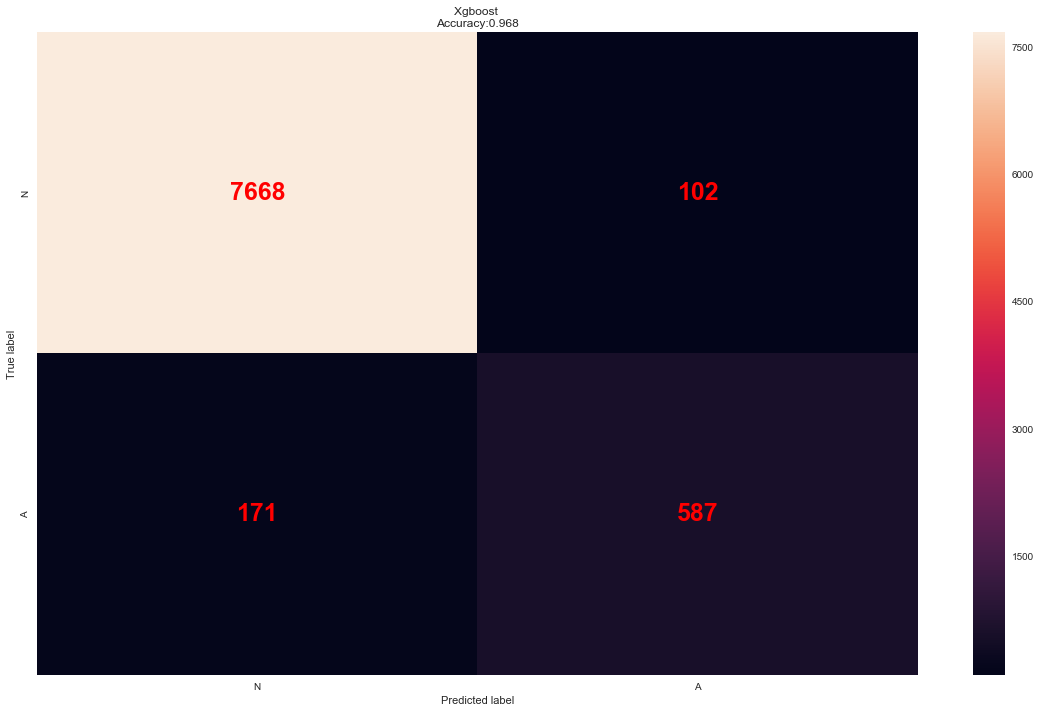

In [381]:
display_confusion_matrix(oof,train_labels.values)

In [382]:
def display_importances(model_name,feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 16))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('{0} Features (avg over folds)'.format(model_name))
    plt.tight_layout()
    plt.show()
    
    return cols

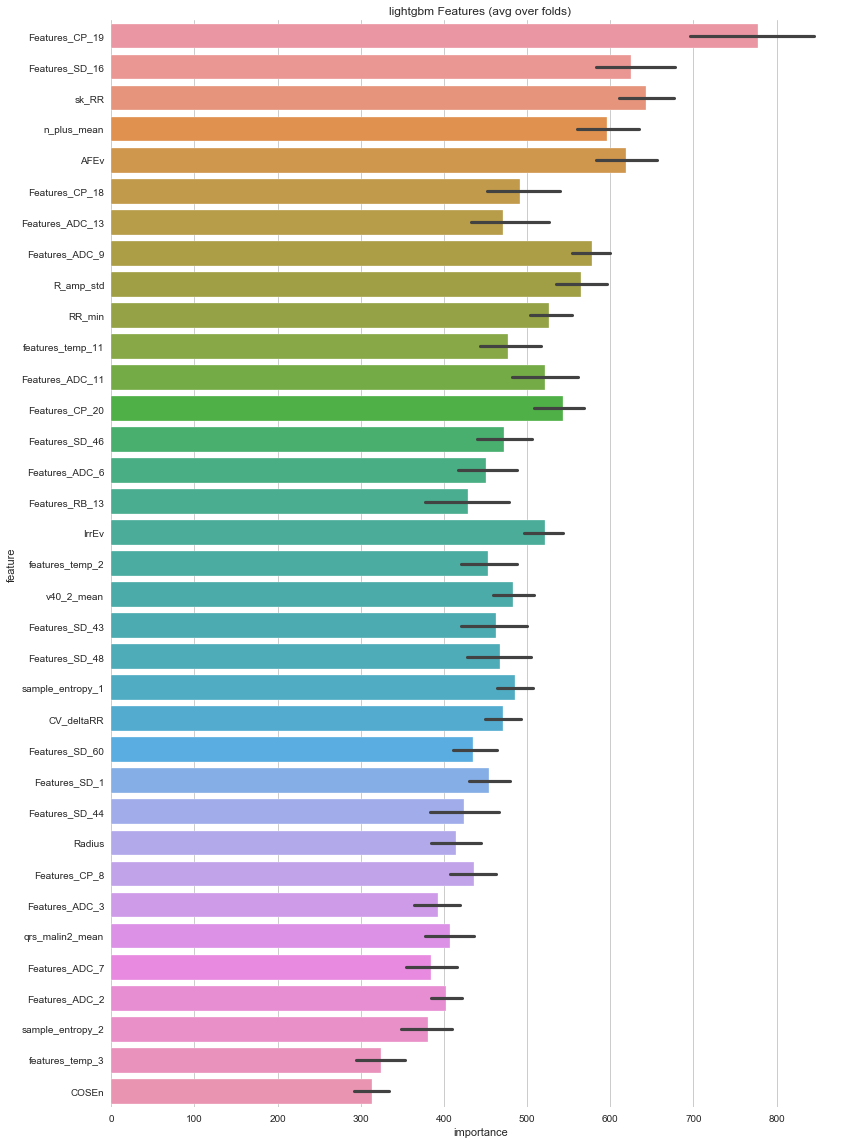

In [383]:
#feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:200].index.tolist()
top_fea = display_importances("lightgbm",feature_importance_df)

In [384]:
feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index.tolist()

['Features_CP_19',
 'sk_RR',
 'Features_SD_16',
 'AFEv',
 'n_plus_mean',
 'Features_ADC_9',
 'R_amp_std',
 'Features_CP_20',
 'RR_min',
 'Features_ADC_11',
 'IrrEv',
 'Features_CP_18',
 'sample_entropy_1',
 'v40_2_mean',
 'features_temp_11',
 'Features_SD_46',
 'CV_deltaRR',
 'Features_ADC_13',
 'Features_SD_48',
 'Features_SD_43',
 'Features_SD_1',
 'features_temp_2',
 'Features_ADC_6',
 'Features_CP_8',
 'Features_SD_60',
 'Features_RB_13',
 'Features_SD_44',
 'Radius',
 'qrs_malin2_mean',
 'Features_ADC_2',
 'Features_ADC_3',
 'Features_ADC_7',
 'sample_entropy_2',
 'features_temp_3',
 'COSEn']

In [350]:
class Predict_afdb(object):
    def __init__(self, path,data_id,preprocess,feature39_name,feature188_name,select_feature_name):
        super(Predict_afdb,self).__init__()
        self.feature39_name = feature39_name
        self.feature188_name = feature188_name
        self.select_feature_name = select_feature_name
        self.preprocess = preprocess
        self.features39_id = []
        self.labels = []
        self.path = path
        self.data_id = data_id
        self.test_data = 0
        self.pred_labels = []
    def _get_id_labels(self):
        with open(os.path.join(self.path,self.data_id+'_features39_id.txt')) as f:
            temp = f.read().splitlines()#[-2909:]
            self.features39_id = [x.split(" ")[0] for x in temp]
            self.labels = [x.split(" ")[-1] for x in temp]
    def _get_merge_features(self):
        self._get_id_labels()
        #print(self.features39_id)
        
        #读取39个特征
        ''' 
        test_features39_pd = pd.read_csv(os.path.join(self.path,self.data_id+'_feat39.csv'))
        test_features39_pd.dropna(inplace=True)
        self.labels = test_features39_pd["label"].values.tolist()
        self.features39_id =  test_features39_pd["ID"].values.tolist()
        test_features39_pd.drop(["ID","label"],axis=1,inplace=True)
        test_features39_pd["id"] = self.features39_id
        #features39_pd.columns = feature39_name
        #features38_pd['id']=file_list
        '''
        features39 = np.loadtxt(os.path.join(self.path,self.data_id+'_features39.txt'))#[-2909:]
        test_features39_pd = pd.DataFrame(data=features39,columns=self.feature39_name)
        test_features39_pd["id"] = self.features39_id
        #print(test_features39_pd.shape)
        
        #读取188个特征
        if self.preprocess == False:
            features188 = np.loadtxt(os.path.join(os.path.join(self.path,data_id),"TH902_features_188_test.txt"))
        else:
            features188 = np.loadtxt(os.path.join(os.path.join(self.path,"results",data_id),"afdb_188features_lead1.txt"))
        features188_pd = pd.DataFrame(features188,columns=self.feature188_name)
        features188_pd['id']=self.features39_id
        #print(features188_pd.shape)
        
        
        #读取38个特征
        wclfeat_test_path = "./wclfeature/afdb_test/"
        features38_pd = pd.read_csv(wclfeat_test_path+data_id+"_feat_id.csv")#,header=None
        #features38_pd.drop(38,axis=1,inplace=True)
        #features38_pd.columns = feature38_name+["label"]   
        #features38_pd['id']=self.features39_id
        #features38_pd.to_csv(wclfeat_test_path+data_id+"_feat_id.csv",index=False)
        #print(features38_pd.shape)
        
        test_data_all = pd.merge(test_features39_pd,features188_pd,on='id')
        test_data_all = pd.merge(test_data_all,features38_pd,on='id')
        self.test_data = test_data_all[self.select_feature_name] #feature39_name feature_name
        
        self.labels = test_data_all["label"]
        #test_data_all.to_csv("test.csv")
        #print(test_data_all[["id","RR_range"]])
        #print("test_data shape: ",self.test_data.shape)
    def _predict(self):
        self._get_merge_features()
        results = []
        num_N=0
        num_A=0
        num_O=0
        num_ = 0
        result=0
        for i in range(self.test_data.shape[0]):
            dfeatures = self.test_data.iloc[i].astype('float64')
            prediction_prob = bst.predict(dfeatures)
            prediction = round(prediction_prob[0])#[round(prediction_prob) for i in prediction_prob] #np.argmax(prediction_prob)
            self.pred_labels.append(prediction)

            if prediction == 0:
                num_N += 1
                pred_label = "N"
                result =self.features39_id[i] + '   N\n'
            elif prediction == 1:
                num_A += 1
                pred_label = "AFIB"
                result = self.features39_id[i]+'   A\n'
            elif prediction == 2:
                num_O += 1
                pred_label = "O"
                result =self.features39_id[i] + '   O\n'
            elif prediction == 3:
                num_ += 1
                pred_label = "~"
                result = self.features39_id[i]+'   ~\n'

            results.append(result)
            #pred_labels.append(pred_label)
            #print(test_data_all.iloc[i].loc['id'])
            #print("********* result :************ ", result)
        print("\n************************\n")
        print("data_id =  " ,self.data_id)
        print("num_N = %d  :" % num_N)
        print("num_A = %d  :" % num_A)
        print("num_O = %d  :" % num_O)
        print("num_  = %d  :" % num_ )
        
        return results
    def _perf_measure(self,y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for i in range(len(y_hat)): 
            if y_actual[i]==y_hat[i]==1:
                TP += 1
            if y_hat[i]==1 and y_actual[i]!=1:
                FP += 1
            if y_actual[i]!=1 and y_actual[i]!=1:
                TN += 1
            if y_hat[i]!=1 and y_actual[i]==1:
                FN += 1
        #TP, FP, TN, FN = perf_measure(train_labels.values,pred_labels)

        print("TP, FP, TN, FN == ",TP, FP, TN, FN)

        SE = TP / (TP + FN+ 0.00001)
        print("召回率或灵敏度 SE = TP / (TP + FN) == ",SE)

        SP = TN / (TN + FP+0.00001)
        print("特异性 SP = TN / (TN + FP) == ",SP)

        PPV = TP / (TP + FP+ 0.00001)
        print("阳性预测值 PPV = TP / (TP + FP) == ",PPV)
        
        Recall       = TP / (TP + FN + 0.00001)
        Precision    = TP / (TP + FP + 0.00001)
        Specificity  = TN / (TN + FP + 0.00001); # 1-FPR
        Acc          = (TP + TN) / (TP + TN + FP + FN)

        print("Recall :",Recall)
        print("Precision :",Precision)
        print("Specificity :",Specificity)
        print("Acc :",Acc)

        return TP, FP, TN, FN,SE, SP, PPV, Acc
    def display_confusion_matrix(self):
        results = self._predict()
        # Creates a confusion matrix
        map_dict = {"N":0,"AFIB":1,"AFL":1,"O":0,"~":0,"J":0}#AFIB
        train_labels = pd.Series(self.labels)#.map(map_dict)
        
        columns = pd.Series(self.labels).value_counts().index.values
        print("true_labels : \n",train_labels.value_counts())
        y_true = train_labels.values
        y_pred = self.pred_labels
        
        cm = confusion_matrix(y_true,y_pred)
        if cm.shape == (2,2):
            cm_df = pd.DataFrame(cm,
                                     index = ['A','O'], 
                                     columns = ['A','O'])
        else:
            # Transform to df for easier plotting
            try:
                cm_df = pd.DataFrame(cm,
                                 index = ['N','A','O','~'], 
                                 columns = ['N','A','O','~'])
            except ValueError:
                cm_df = pd.DataFrame(cm,
                                 index = ['N','A','O'], 
                                 columns = ['N','A','O'])
        ''' 
        plt.figure(figsize=(16,10))
        sns.heatmap(cm_df, annot=True,annot_kws={'size':25,'weight':'bold', 'color':'r'},fmt="d")#,cmap="RdBu"
        plt.title('Xgboost \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred,y_true)))
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        #plt.show()
        '''
        TP, FP, TN, FN,SE, SP, PPV, Acc = self._perf_measure(y_true,y_pred)
        
        return self.data_id,self.test_data.shape[0],TP, FP, TN, FN,SE, SP, PPV, Acc#,results

In [385]:
import lightgbm as lgb 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

bst = lgb.Booster(model_file='lightgbm_0510_groupfeat_2_35_tiaocan.bin')  #lgb.bin  lightgbm_0327

In [386]:
select_feature_name = feature_name
len(select_feature_name)

35

In [387]:
result = pd.DataFrame(columns=["ID","samples","TP", "FP", "TN", "FN","SE","SP","PPV","ACC"])

data_id_lists = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995',
                 '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455']

#data_id_lists = ["04048"]
path = "./AFdb_TEST0/"
for data_id in data_id_lists:
    predict_afdb = Predict_afdb(path,data_id,True,feature39_name,feature188_name,select_feature_name)
    ID,num,TP, FP, TN, FN,SE, SP, PPV, Acc = predict_afdb.display_confusion_matrix()
    result.loc[result.shape[0]] = ID,num,TP, FP, TN, FN,SE, SP, PPV, Acc


************************

data_id =   04015
num_N = 1203  :
num_A = 26  :
num_O = 0  :
num_  = 0  :
true_labels : 
 0    1221
1       8
Name: label, dtype: int64
TP, FP, TN, FN ==  8 18 1221 0
召回率或灵敏度 SE = TP / (TP + FN) ==  0.9999987500015626
特异性 SP = TN / (TN + FP) ==  0.98547214700991
阳性预测值 PPV = TP / (TP + FP) ==  0.30769218934915793
Recall : 0.9999987500015626
Precision : 0.30769218934915793
Specificity : 0.98547214700991
Acc : 0.9855653568564555

************************

data_id =   04043
num_N = 977  :
num_A = 277  :
num_O = 0  :
num_  = 0  :
true_labels : 
 0    978
1    276
Name: label, dtype: int64
TP, FP, TN, FN ==  260 17 978 16
召回率或灵敏度 SE = TP / (TP + FN) ==  0.9420289513757627
特异性 SP = TN / (TN + FP) ==  0.9829145629857833
阳性预测值 PPV = TP / (TP + FP) ==  0.9386281249592735
Recall : 0.9420289513757627
Precision : 0.9386281249592735
Specificity : 0.9829145629857833
Acc : 0.9740361919748229

************************

data_id =   04048
num_N = 1162  :
num_A = 67  :
num_O = 0

In [388]:
result.to_csv("lead0_result_0510_2_35_tiaocan_1.csv",index=False)#lead0_result

# LightGBM调参

In [355]:
from sklearn import metrics
def report_metrics(y_true,y_predict): 
    print('准确率:', metrics.accuracy_score(y_true, y_predict)) #预测准确率输出

    print('宏平均精确率:',metrics.precision_score(y_true,y_predict,average='macro')) #预测宏平均精确率输出
    print('微平均精确率:', metrics.precision_score(y_true, y_predict, average='micro')) #预测微平均精确率输出
    print('加权平均精确率:', metrics.precision_score(y_true, y_predict, average='weighted')) #预测加权平均精确率输出

    print('宏平均召回率:',metrics.recall_score(y_true,y_predict,average='macro'))#预测宏平均召回率输出
    print('微平均召回率:',metrics.recall_score(y_true,y_predict,average='micro'))#预测微平均召回率输出
    print('加权平均召回率:',metrics.recall_score(y_true,y_predict,average='micro'))#预测加权平均召回率输出

    print('宏平均F1-score:',metrics.f1_score(y_true,y_predict,labels=[0,1,2,3],average='macro'))#预测宏平均f1-score输出
    print('微平均F1-score:',metrics.f1_score(y_true,y_predict,labels=[0,1,2,3],average='micro'))#预测微平均f1-score输出
    print('加权平均F1-score:',metrics.f1_score(y_true,y_predict,labels=[0,1,2,3],average='weighted'))#预测加权平均f1-score输出

    print('混淆矩阵输出:\n',metrics.confusion_matrix(y_true,y_predict,labels=[0,1,2,3]))#混淆矩阵输出
    print('分类报告:\n', metrics.classification_report(y_true, y_predict,labels=[0,1,2,3]))#分类报告输出

In [356]:
import lightgbm as lgb
from sklearn import metrics
#构建xgb模型并进行交叉验证，该模型可以验证更新后的模型好坏
#定义modelfit函数，根据一定的学习率得到最优迭代次数
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_params()
        xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain["label"].values,silent=True)
        #xgb.DMatrix(dtrain[predictors].values, label=dtrain["label"].values)
        cvresult = lgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            early_stopping_rounds=early_stopping_rounds, verbose_eval=20)
        alg.set_params(n_estimators=len(cvresult["binary_logloss-stdv"]))
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='binary_logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print("estimators num : {0}".format(len(cvresult["binary_logloss-stdv"])))
    #print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    #print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))
    cinc_f1_score(dtrain['label'].values, dtrain_predictions)
    report_metrics(dtrain['label'].values, dtrain_predictions)
    
    return alg

In [357]:
def display_importances(model_name,feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('{0} Features (avg over folds)'.format(model_name))
    plt.tight_layout()
    plt.show()

In [371]:
predictors = feature_name
print(len(feature_name))
lgb1 = LGBMClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary',
 num_class= 1,
 n_jobs=4,
 #class_weight ="1",
 random_state =27)

model = modelfit(lgb1, train_df, predictors)

35
[20]	cv_agg's binary_logloss: 0.544625 + 0.000725219
[40]	cv_agg's binary_logloss: 0.439171 + 0.00120886
[60]	cv_agg's binary_logloss: 0.361374 + 0.0017404
[80]	cv_agg's binary_logloss: 0.302598 + 0.00209915
[100]	cv_agg's binary_logloss: 0.257395 + 0.00249468
[120]	cv_agg's binary_logloss: 0.222334 + 0.00289383
[140]	cv_agg's binary_logloss: 0.194788 + 0.00329546
[160]	cv_agg's binary_logloss: 0.172917 + 0.00367798
[180]	cv_agg's binary_logloss: 0.1555 + 0.00410069
[200]	cv_agg's binary_logloss: 0.141597 + 0.00444269
[220]	cv_agg's binary_logloss: 0.130563 + 0.00485692
[240]	cv_agg's binary_logloss: 0.121674 + 0.00511973
[260]	cv_agg's binary_logloss: 0.114499 + 0.00531821
[280]	cv_agg's binary_logloss: 0.108696 + 0.00564801
[300]	cv_agg's binary_logloss: 0.104027 + 0.00584034
[320]	cv_agg's binary_logloss: 0.100183 + 0.00598948
[340]	cv_agg's binary_logloss: 0.097173 + 0.00617237
[360]	cv_agg's binary_logloss: 0.0947468 + 0.00635087
[380]	cv_agg's binary_logloss: 0.0928256 + 0.006

In [372]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 1,
 'min_split_gain': 0.0,
 'n_estimators': 661,
 'n_jobs': 4,
 'num_class': 1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 27,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 1}

In [361]:
from sklearn.model_selection import GridSearchCV
### 我们可以创建lgb的sklearn模型，使用上面选择的(学习率，评估器数目)

lgb1 = LGBMClassifier(
 learning_rate =0.1,
 n_estimators=62,
 max_depth=5,
 num_leaves=50,
 min_child_weight=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary',
 num_class= 1,
 n_jobs=4,
 #class_weight ="1",
 random_state =27)

params_test1={
    'max_depth': range(3,8,2),
    'num_leaves':range(50, 170, 30)
}

gsearch1 = GridSearchCV(estimator=lgb1, param_grid=params_test1, scoring='f1_micro', cv=5, verbose=1, n_jobs=4)
gsearch1.fit(train_df[predictors],train_df["label"])
#gsearch1.grid_scores_, 
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.7s finished


({'max_depth': 3, 'num_leaves': 50}, 0.9685741088180112)

In [362]:
params_test2={
    'max_depth': [2,3,4,5],
    'num_leaves':[30,40,50,60,70]
}

gsearch2 = GridSearchCV(estimator=lgb1, param_grid=params_test2, scoring='f1_micro', cv=5, verbose=1, n_jobs=4)
gsearch2.fit(train_df[predictors],train_df["label"])
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.4s finished


({'max_depth': 3, 'num_leaves': 30}, 0.9685741088180112)

In [363]:
lgb3 = LGBMClassifier(
 learning_rate =0.1,
 n_estimators=62,
 max_depth=3,
 num_leaves=30,
 min_child_weight=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary',
 num_class= 1,
 n_jobs=4,
 #class_weight ="1",
 random_state =27)

params_test3={
    'min_child_samples': [18, 19, 20, 21, 22],
    'min_child_weight':[0.001, 0.002]
}
gsearch3 = GridSearchCV(estimator=lgb3, param_grid=params_test3, scoring='f1_micro', cv=5, verbose=1, n_jobs=-4)
gsearch3.fit(train_df[predictors],train_df["label"])
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-4)]: Done  32 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-4)]: Done  50 out of  50 | elapsed:    3.0s finished


({'min_child_samples': 20, 'min_child_weight': 0.001}, 0.9685741088180112)

In [364]:
lgb3 = LGBMClassifier(
 learning_rate =0.1,
 n_estimators=62,
 max_depth=3,
 num_leaves=30,
 min_child_weight=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary',
 num_class= 1,
 n_jobs=4,
 #class_weight ="1",
 random_state =27)

params_test3={
    'min_child_samples': [17,18, 19],
    'min_child_weight':[0.0005,0.001]
}
gsearch3 = GridSearchCV(estimator=lgb3, param_grid=params_test3, scoring='f1_micro', cv=5, verbose=1, n_jobs=-4)
gsearch3.fit(train_df[predictors],train_df["label"])
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-4)]: Done  30 out of  30 | elapsed:    1.2s finished


({'min_child_samples': 19, 'min_child_weight': 0.0005}, 0.9681050656660413)

In [365]:
lgb4 = LGBMClassifier(
 learning_rate =0.1,
 n_estimators=62,
 max_depth=3,
 num_leaves=30,
 min_child_weight=0.0005,
 min_child_samples=19,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary',
 num_class= 1,
 n_jobs=4,
 #class_weight ="1",
 random_state =27)


params_test4={
    'colsample_bytree': [0.7, 0.8, 0.9,1],
    'subsample': [0.7, 0.8, 0.9,1]
}
gsearch4 = GridSearchCV(estimator=lgb4, param_grid=params_test4, scoring='f1_micro', cv=5, verbose=1, n_jobs=-4)
gsearch4.fit(train_df[predictors],train_df["label"])
gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-4)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-4)]: Done  80 out of  80 | elapsed:    3.1s finished


({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9684568480300187)

In [366]:

lgb5 = LGBMClassifier(
 learning_rate =0.1,
 n_estimators=62,
 max_depth=3,
 num_leaves=30,
 min_child_weight=0.0005,
 min_child_samples=19,
 subsample=0.9,
 colsample_bytree=0.7,
 objective='binary',
 num_class= 1,
 n_jobs=4,
 #class_weight ="1",
 random_state =27)

params_test5={
    'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}

gsearch5 = GridSearchCV(estimator=lgb5, param_grid=params_test5, scoring='f1_micro', cv=5, verbose=1, n_jobs=4)
gsearch5.fit(train_df[predictors],train_df["label"])
gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 245 out of 245 | elapsed:    9.5s finished


({'reg_alpha': 0.08, 'reg_lambda': 0.001}, 0.9689258911819888)

In [368]:
lgb1 = LGBMClassifier(
 learning_rate =0.01,
 n_estimators=62,
 max_depth=3,
 num_leaves=30,
 min_child_weight=0.0005,
 min_child_samples=19,
 subsample=0.9,
 colsample_bytree=0.7,
 objective='binary',
 reg_alpha=0.08,
 reg_lambda = 0.001,
 num_class= 1,
 n_jobs=4,
 #class_weight ="1",
 random_state =27)

model = modelfit(lgb1, train_df, predictors)

[20]	cv_agg's binary_logloss: 0.546949 + 0.000667261
[40]	cv_agg's binary_logloss: 0.442923 + 0.00108852
[60]	cv_agg's binary_logloss: 0.366032 + 0.00161094

Model Report
estimators num : 62
F1 measure for Normal rhythm: 0.9824
F1 measure for AF rhythm: 0.8043
F1 measure for Other rhythm: nan
F1 measure for Noisy recordings: nan
Final F1 measure: nan
准确率: 0.9676360225140713
宏平均精确率: 0.9226905065322312
微平均精确率: 0.9676360225140713
加权平均精确率: 0.966317023429333
宏平均召回率: 0.8685407986199543
微平均召回率: 0.9676360225140713
加权平均召回率: 0.9676360225140713
宏平均F1-score: 0.4466537569251607
微平均F1-score: 0.9676360225140713
加权平均F1-score: 0.9665291354786179
混淆矩阵输出:
 [[7685   85    0    0]
 [ 191  567    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]
分类报告:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      7770
           1       0.87      0.75      0.80       758
           2       0.00      0.00      0.00         0
           3       0.00      0.00    